<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/04_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Deep Q-Network implementation
包括三个组成部分：

- approximate q-learning
- experience replay
- target networks 

In [0]:
import os
os.system('apt-get install -y xvfb')
os.system('apt-get install graphviz')
os.system('pip install pydot pydot-ng')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')



if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


### 目标: 训练一个玩atari的agent
游戏数据信息：
- atari 游戏画面图像默认大小是210x160x3

为了节省时间，可以对图像进行resize操作，变成64x64的黑白图像。并且去除顶部和底部无用的图像区域。

In [0]:
from gym.core import ObservationWrapper
from gym.spaces import Box
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (64, 64)
        self.observation_space = Box(0.0, 1.0, (*self.img_size,1))
        print("self.observation_space={0}".format(self.observation_space.shape))

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize imported above or any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type

        # crop image
        img=img[20:,:,:]
        # resize
        img = Image.fromarray(img.astype(np.uint8))
        img = img.resize((self.img_size[0], self.img_size[1]),Image.ANTIALIAS)
        #print("process")
        #plt.imshow(img,cmap="gray")
        #plt.show()
        # 灰度
        img = img.convert('L')

        #归一化：
        imgdata=np.array(img.getdata(),dtype='float32')
        mean_val = np.min(imgdata)
        max_val = np.max(imgdata)
        imgdata = (imgdata-mean_val)/max_val
        imgdata = imgdata.reshape((*self.img_size,1))
        #print("imgdata[0,:]".format(imgdata[0,:]))
        #print("imgdata shape={0}".format(imgdata.shape))
        return imgdata

In [0]:
import gym
env = gym.make("BreakoutDeterministic-v4")
observation_shape = env.observation_space.shape
print("observation_shape={0}".format(observation_shape))
env = PreprocessAtari(env)
observation_shape = env.observation_space.shape
print("observation_shape={0}".format(observation_shape))
n_actions = env.action_space.n
obs = env.reset()


observation_shape=(210, 160, 3)
self.observation_space=(64, 64, 1)
observation_shape=(64, 64, 1)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


(64, 64, 1)
(64, 64, 1)
float32
Formal tests seem fine. Here's an example of what you'll get.


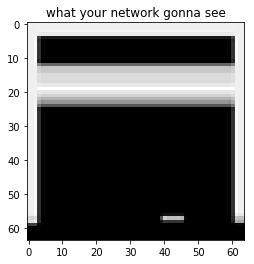

In [0]:
assert obs.ndim == 3, "observation must be [batch, time, channels] even if there's just one channel"
print(obs.shape)
print(observation_shape)
#assert obs.shape == observation_shape
print(obs.dtype)
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
#assert 0 <= np.min(obs) and np.max(
#    obs) <= 1, "convert image pixels to (0,1) range"
print ("Formal tests seem fine. Here's an example of what you'll get.")

plt.title("what your network gonna see")
plt.imshow(obs.reshape([64,64]), interpolation='none', cmap='gray')


### Frame Buffer

单张图片训练时无法反应图片的速度和运动反向。所以这个实验采用连续四张图片进行训练

In [0]:
import numpy as np
from gym.spaces.box import Box
from gym.core import Wrapper
import gym
import matplotlib.pyplot as plt


class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            obs_shape = [height, width, n_channels * n_frames]
        elif dim_order == 'pytorch':
            n_channels, height, width = env.observation_space.shape
            obs_shape = [n_channels * n_frames, height, width]
        else:
            raise ValueError(
                'dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        #print("frame")
        #plt.imshow(new_img.reshape(64,64),cmap="gray")
        #plt.show()
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        elif self.dim_order == 'pytorch':
            offset = self.env.observation_space.shape[0]
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset]
        self.framebuffer = np.concatenate(
            [img, cropped_framebuffer], axis=axis)
        
#包括图片预处理和frame buffer功能的env
def make_env():
    #env = gym.make("BreakoutDeterministic-v0")
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    print("env.observation_space.shape={0}".format(env.observation_space.shape))
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    print("env.observation_space.shape={0}".format(env.observation_space.shape))
    return env

打印env的相关信息

In [0]:
env = make_env()
s0 = env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
print(state_dim)

self.observation_space=(64, 64, 1)
env.observation_space.shape=(64, 64, 1)
env.observation_space.shape=(64, 64, 4)
(64, 64, 4)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### 查看动作的含义
- 0: 没有动作
- 1: 小球动
- 2: 挡板向右移动
- 3: 挡板向左移动

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


self.observation_space=(64, 64, 1)
env.observation_space.shape=(64, 64, 1)
env.observation_space.shape=(64, 64, 4)
[0, 1, 2, 3]
------------------------------------------
render


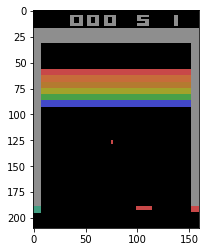

action=1


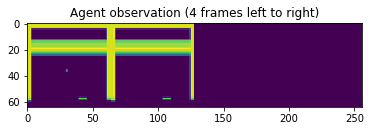

------------------------------------------
render


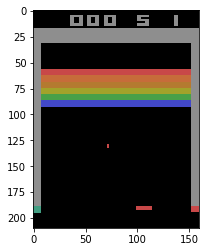

action=1


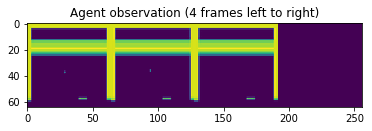

------------------------------------------
render


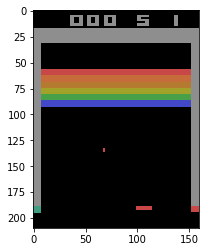

action=1


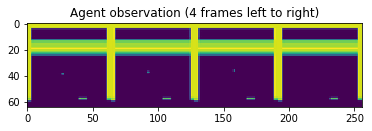

------------------------------------------
render


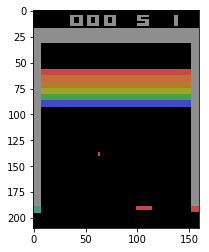

action=1


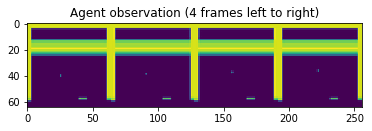

------------------------------------------
render


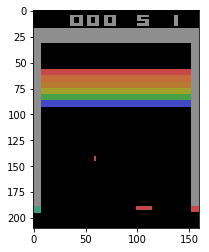

action=1


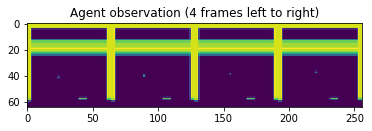

------------------------------------------
render


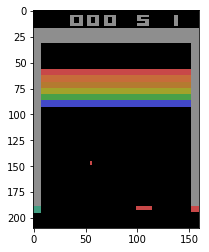

action=1


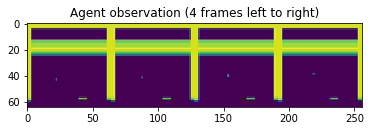

------------------------------------------
render


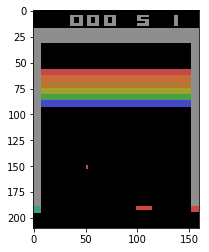

action=1


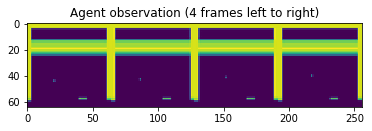

------------------------------------------
render


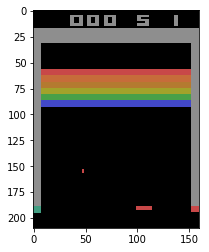

action=1


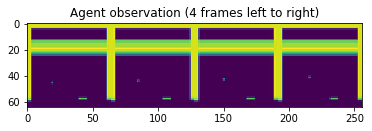

------------------------------------------
render


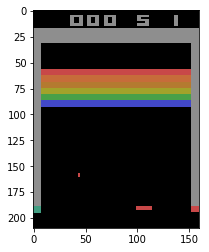

action=1


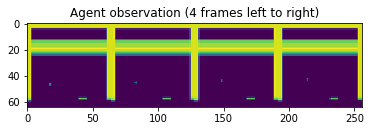

{False}


In [0]:

import numpy as np
import time
env = make_env()
s = env.reset()
result = set()
print(list(range(n_actions)))
for i in range(1,10):
  print("------------------------------------------")
  a = np.random.choice(list(range(n_actions)))
  a = 1
  s,r,done,_ = env.step(a)
  print("render")
  plt.imshow(env.render("rgb_array"))
  plt.show()
  
  if i % 1 == 0:
    print("action={0}".format(a))
    #plt.imshow(s)
    #plt.show()
    plt.title("Agent observation (4 frames left to right)")
    
    images = s.transpose([0, 2, 1]).reshape([state_dim[0],-1])
    plt.imshow(images)
    plt.show()
    #for i in range(1):
    #  img = s[:,:,i].reshape(64,64)
    #  plt.imshow(img,cmap='gray')
    #  plt.show()
    #time.sleep(2)
  
  result.add(done)
  if done:
    print("======================\n\n========================")
    print("done,i={0}".format(i))
    break
print(result)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


self.observation_space=(64, 64, 1)
env.observation_space.shape=(64, 64, 1)
env.observation_space.shape=(64, 64, 4)


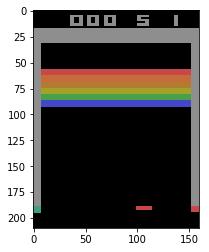

action=0


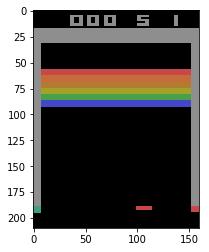

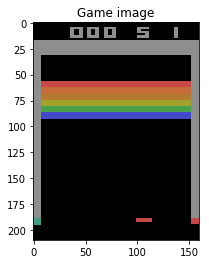

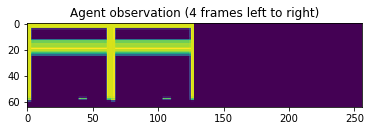

In [0]:
env = make_env()
env.reset()
plt.imshow(env.render("rgb_array"))
plt.show()
for _ in range(1):
    action = env.action_space.sample()
    obs, _, _, _ = env.step(action)
    print("action={0}".format(action))
    plt.imshow(env.render("rgb_array"))
    plt.show()


plt.title("Game image")
# 当前的state
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([state_dim[0], -1]))

### 网络

In [0]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Input, Dense
from keras.layers import Conv2D, Dense, Flatten, InputLayer, MaxPooling2D


Using TensorFlow backend.


In [0]:
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0.5, reuse=False):
        self.n_actions = n_actions
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            
            #< Define your network body here. Please make sure you don't use any layers created elsewhere >
            # prepare a graph for agent step
            # 定义placeholder，接受(s, rewrad, action, next_state, is_done)
            '''
            self.states_ph = K.placeholder(dtype='float32', shape=(None,*state_shape))
            self.actions_ph = K.placeholder(dtype='int32', shape=(None))
            self.rewards_ph = K.placeholder(dtype='float32', shape=(None))
            self.next_states_ph = K.placeholder(dtype='float32', shape=(None,*state_shape))
            self.is_done_ph = K.placeholder(dtype='bool', shape=(None))
            '''
            self.img_size = 64
            #self.gamma = 0.99
            self.network = keras.models.Sequential()
            self.network.add(InputLayer(state_shape))
            self.network.add(Conv2D(filters=16, kernel_size=3, strides=2, activation='relu'))
            self.network.add(Conv2D(filters=32, kernel_size=3, strides=2, activation='relu'))
            self.network.add(Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'))
            #self.network.add(MaxPooling2D(pool_size=(2,2)))
            self.network.add(Flatten())
            self.network.add(Dense(units=256, activation="relu"))
            self.network.add(Dense(units=n_actions))
            
            
            # 定义损失函数
            '''
            predicted_qvalues = self.network(self.states_ph)
            self.qvalues_t = predicted_qvalues
            predicted_next_qvalues = self.network(self.next_states_ph)
            predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(self.actions_ph, n_actions), axis=1)
            next_state_values = K.max(predicted_next_qvalues, axis=-1)
            target_qvalues_for_actions = self.rewards_ph + (next_state_values * self.gamma)
            target_qvalues_for_actions = tf.where(self.is_done_ph, self.rewards_ph, target_qvalues_for_actions)
            loss_val = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2
            self.loss = tf.reduce_mean(loss_val)
            

            # 优化目标
            self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss)
            #self.network.compile(loss='mean_squared_error',optimizer='sgd', metrics=['accuracy'])
            '''

            self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
            self.epsilon = epsilon
            



    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)
        print("qvalues={0}".format(qvalues))

        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(
                qvalues)
        assert int(qvalues.shape[1]) == self.n_actions

        return qvalues

    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        return self.network.predict(state_t)
        #return sess.run(self.qvalues_t, {self.states_ph: state_t})

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-self.epsilon, self.epsilon])
        return np.where(should_explore, random_actions, best_actions)


state_dim=(64, 64, 4)





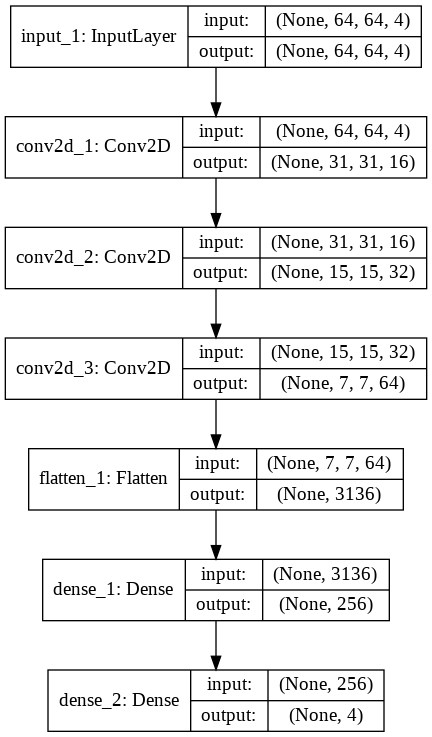

In [0]:
sess = tf.InteractiveSession()
keras.backend.set_session(sess)
keras.backend.get_session().run(tf.global_variables_initializer())

print("state_dim={0}".format(state_dim))
agent = DQNAgent(name="xww", state_shape=state_dim, n_actions=n_actions)
plot_model(agent.network, show_shapes=True, show_layer_names=True, to_file='model.png')


In [0]:

def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            #print("---")
            qvalues = agent.get_qvalues(np.array([s]))
            action = qvalues.argmax(
                axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            #print(action)
            s, r, done, _ = env.step(action)
            #print(np.mean(s))
            #print(done)
            #print(action)
            #print(r)
            reward += r
            if done:
              #print("break")
              #s = env.reset()
              print("reward={0}".format(reward))
              break

        rewards.append(reward)
    return np.mean(rewards)

In [0]:
evaluate(env, agent, n_games=1, t_max=10000)

break


3.0

#### experience replay

In [0]:
import random
import queue


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = queue.Queue()
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return self._storage.qsize()

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize. 
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        # add data to storage
        if self._storage.qsize() < self._maxsize:
          self._storage.put(data)
        else:
          self._storage.get()
          self._storage.put(data)
          #print("size={0}".format(self._storage.qsize()))

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        #idxes = <randomly generate batch_size integers to be used as indexes of samples >

        # collect <s,a,r,s',done> for each index
        if batch_size > self._storage.qsize():
          batch_size = self._storage.qsize()
        samples = random.sample(self._storage.queue, batch_size)
        states = [i[0] for i in samples]
        actions = [i[1] for i in samples]
        rewards = [i[2] for i in samples]
        next_states = [i[3] for i in samples]
        is_dones = [i[4] for i in samples]


        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(is_dones)


测试验证experience relay

In [0]:
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

play and record

In [0]:
agent.epsilon = 0.5
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time
    """
    # initial state
    s = env.framebuffer
    
    # Play the game for n_steps as per instructions above
    reward = 0
    for _ in range(n_steps):
        qvalues = agent.get_qvalues(np.array([s]))
        action = agent.sample_actions(qvalues)[0]
        s_next, r, done, _ = env.step(action)
        exp_replay.add(s, action, r, s_next, done)
        if done:
          #print("reset")
          s = env.reset()
        s = s_next
        reward += r
    
    return reward

In [0]:
# testing your code. This may take a minute...
exp_replay = ReplayBuffer(20000)

play_and_record(agent, env, exp_replay, n_steps=10000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 10000, "play_and_record should have added exactly 10000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage.queue))[-1]
print("size is_dons={0}".format(len(is_dones)))
print("mean is_dons={0}".format(np.mean(is_dones)))
assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_dim
    assert act_batch.shape == (
        10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [
        0 <= a <= n_actions for a in act_batch], "actions should be within [0, n_actions]"

print("Well done!")

size is_dons=10000
mean is_dons=0.005
Well done!


### 利用experience replay进行训练

In [0]:
'''
env = make_env()
exp_replay = ReplayBuffer(20000)
batch_size = 64
def generate_session(t_max=1000, epsilon=0.2, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    for t in range(t_max):
        qvalues = agent.get_qvalues(np.array([s]), sess)
        a = agent.sample_actions(qvalues, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        if t == 0:
          exp_replay.add(s,a,r,next_s,done)
        batch_s, batch_a, batch_r, batch_next_s, batch_done = exp_replay.sample(batch_size=64)
        #print(batch_s.shape)
        #print(np.array([s]).shape)
        batch_s = np.append(batch_s, np.array([s]),axis=0)
        batch_a = np.append(batch_a, a)
        batch_r = np.append(batch_r, r)
        batch_next_s = np.append(batch_next_s, np.array([next_s]),axis=0)
        batch_done = np.append(batch_done, done)
        exp_replay.add(s,a,r,next_s,done)
        #print(batch_s.shape)
        if train:
            sess.run(agent.train_step,{
                agent.states_ph: batch_s, agent.actions_ph: batch_a, agent.rewards_ph: batch_r, 
                agent.next_states_ph: batch_next_s, agent.is_done_ph: batch_done
            })

        total_reward += r
        s = next_s
        if done: 
          #print("is done")
          break
    return total_reward
'''

'\nenv = make_env()\nexp_replay = ReplayBuffer(20000)\nbatch_size = 64\ndef generate_session(t_max=1000, epsilon=0.2, train=False):\n    """play env with approximate q-learning agent and train it at the same time"""\n    total_reward = 0\n    s = env.reset()\n    for t in range(t_max):\n        qvalues = agent.get_qvalues(np.array([s]), sess)\n        a = agent.sample_actions(qvalues, epsilon=epsilon)       \n        next_s, r, done, _ = env.step(a)\n        if t == 0:\n          exp_replay.add(s,a,r,next_s,done)\n        batch_s, batch_a, batch_r, batch_next_s, batch_done = exp_replay.sample(batch_size=64)\n        #print(batch_s.shape)\n        #print(np.array([s]).shape)\n        batch_s = np.append(batch_s, np.array([s]),axis=0)\n        batch_a = np.append(batch_a, a)\n        batch_r = np.append(batch_r, r)\n        batch_next_s = np.append(batch_next_s, np.array([next_s]),axis=0)\n        batch_done = np.append(batch_done, done)\n        exp_replay.add(s,a,r,next_s,done)\n      

In [0]:
'''
epsilon = 0.4
import time
for i in range(1000):
    start = time.time()
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(10)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}\ttime_cost={}\texp_replay size={}".format(i, np.mean(session_rewards), epsilon, time.time()-start,len(exp_replay)))
    
    epsilon= max(epsilon*0.99,0.01)
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 10:
        print ("You Win!")
        break
'''
'''
TPU耗时：
  epoch #0	mean reward = 1.220	epsilon = 0.500	time_cost=122.46886038780212
  epoch #1	mean reward = 1.150	epsilon = 0.495	time_cost=118.8068995475769
  epoch #2	mean reward = 1.360	epsilon = 0.490	time_cost=121.57082295417786
  epoch #3	mean reward = 1.620	epsilon = 0.485	time_cost=155.45745730400085
  epoch #4	mean reward = 1.670	epsilon = 0.480	time_cost=175.2912380695343
GPU耗时：
  epoch #0	mean reward = 1.360	epsilon = 0.500	time_cost=176.7485010623932
  epoch #1	mean reward = 1.830	epsilon = 0.495	time_cost=190.0246570110321
  epoch #2	mean reward = 1.840	epsilon = 0.490	time_cost=193.792795419693
  epoch #3	mean reward = 1.510	epsilon = 0.485	time_cost=185.10718274116516
  epoch #5	mean reward = 1.850	epsilon = 0.475	time_cost=186.9741883277893

'''

'\nTPU耗时：\n  epoch #0\tmean reward = 1.220\tepsilon = 0.500\ttime_cost=122.46886038780212\n  epoch #1\tmean reward = 1.150\tepsilon = 0.495\ttime_cost=118.8068995475769\n  epoch #2\tmean reward = 1.360\tepsilon = 0.490\ttime_cost=121.57082295417786\n  epoch #3\tmean reward = 1.620\tepsilon = 0.485\ttime_cost=155.45745730400085\n  epoch #4\tmean reward = 1.670\tepsilon = 0.480\ttime_cost=175.2912380695343\nGPU耗时：\n  epoch #0\tmean reward = 1.360\tepsilon = 0.500\ttime_cost=176.7485010623932\n  epoch #1\tmean reward = 1.830\tepsilon = 0.495\ttime_cost=190.0246570110321\n  epoch #2\tmean reward = 1.840\tepsilon = 0.490\ttime_cost=193.792795419693\n  epoch #3\tmean reward = 1.510\tepsilon = 0.485\ttime_cost=185.10718274116516\n  epoch #5\tmean reward = 1.850\tepsilon = 0.475\ttime_cost=186.9741883277893\n\n'

### Target networks

In [0]:
print("state_dim={0}".format(state_dim))
print("n_actions={0}".format(n_actions))
target_network = DQNAgent("target_network", state_dim, n_actions)
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    # tf.get_default_session().run(assigns)
    return assigns
# create the tf copy graph only once.
copy_step = load_weigths_into_target_network(agent, target_network)
sess.run(copy_step)
# check that it works
sess.run([tf.assert_equal(w, w_target)
          for w, w_target in zip(agent.weights, target_network.weights)])
print("It works!")

state_dim=(64, 64, 4)
n_actions=4
It works!


### 学习
1. 玩10步，更新experience replay中的数据，
2. sample一个batch的数据，更新agent的权重。。
2. 每500个batch,更新target network的权重。

大概需要训练$10^5$个batch的数据

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$
With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$
Where

$Q_{target}(s',a')$ denotes q-value of next state and next action predicted by target_network
$s, a, r, s'$ are current state, action, reward and next state respectively
$\gamma$ is a discount factor defined two cells above.

In [0]:
# placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.bool, shape=[None])

#is_not_done = 1 - tf.cast(is_done_ph,tf.int16)
gamma = 0.99

In [0]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=-1)

next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph)
next_state_values_target = K.max(next_qvalues_target, axis=-1)
reference_qvalues = tf.where(is_done_ph, rewards_ph, rewards_ph + gamma*next_state_values_target)

td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(td_loss)
train_step = tf.train.AdamOptimizer(1e-3).minimize(td_loss, var_list=agent.weights)

qvalues=Tensor("sequential_1/dense_2/BiasAdd:0", shape=(?, 4), dtype=float32)
qvalues=Tensor("sequential_2/dense_4/BiasAdd:0", shape=(?, 4), dtype=float32)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
sess.run(tf.global_variables_initializer())

for chk_grad in tf.gradients(reference_qvalues, agent.weights):
    error_msg = "Reference q-values should have no gradient w.r.t. agent weights. Make sure you used target_network qvalues! "
    error_msg += "If you know what you're doing, ignore this assert."
    assert chk_grad is None or np.allclose(
        sess.run(chk_grad), sess.run(chk_grad * 0)), error_msg

#assert tf.gradients(reference_qvalues, is_done_ph)[
#    0] is not None, "make sure you used is_not_done"
assert tf.gradients(reference_qvalues, rewards_ph)[
    0] is not None, "make sure you used rewards"
assert tf.gradients(reference_qvalues, next_obs_ph)[
    0] is not None, "make sure you used next states"
assert tf.gradients(reference_qvalues, obs_ph)[
    0] is None, "reference qvalues shouldn't depend on current observation!"  # ignore if you're certain it's ok
print("Splendid!")

Splendid!


In [0]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span=100, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

In [0]:
exp_replay = ReplayBuffer(10**5)
play_and_record(agent, env, exp_replay, n_steps=10000)


def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        batch_size)
    return {
        obs_ph: obs_batch, actions_ph: act_batch, rewards_ph: reward_batch,
        next_obs_ph: next_obs_batch, is_done_ph: is_done_batch
    }

buffer size = 100000, epsilon = 0.17291


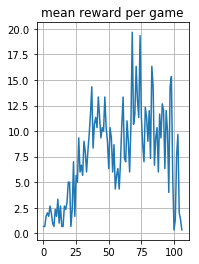

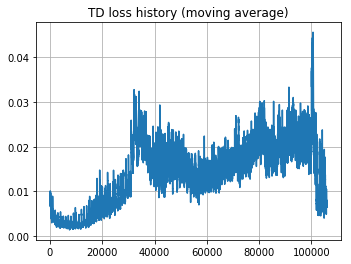


  5%|▍         | 1469/30000 [01:41<29:48, 15.95it/s]

KeyboardInterrupt: ignored

In [0]:
#由于长时间连接导致运行到i=5w次的时候会断裂
#尝试每次运行2w次
for i in trange(30000):

    # play
    play_and_record(agent, env, exp_replay, 10)

    # train
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)

    # adjust agent parameters
    if i % 1000 == 0:
        #load_weigths_into_target_network(agent, target_network)
        # calling 'load_weights_into_target_network' repeatedly cause creating tf copy operator
        # again and again, which bloat memory consumption along training step
        # create'copy_step' once
        sess.run(copy_step)
        agent.epsilon = max(agent.epsilon * 0.99, 0.01)
        mean_rw_history.append(evaluate(make_env(), agent, greedy=False, n_games=3))
    if i % 500 == 0:
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.subplot(1, 2, 1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(
            np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

In [0]:
assert np.mean(mean_rw_history[-10:]) > 10.
print("That's good enough for tutorial.")

That's good enough for tutorial.


In [0]:
np.mean(mean_rw_history[-10:])

10.166666666666666

## 查看视频

In [0]:
agent.epsilon = 0.18
import gym.wrappers
env_monitor = gym.wrappers.Monitor(make_env(), directory="videos", force=True)
sessions = [evaluate(env_monitor, agent, n_games=1) for _ in range(100)]
env_monitor.close()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


self.observation_space=(64, 64, 1)
env.observation_space.shape=(64, 64, 1)
env.observation_space.shape=(64, 64, 4)
reward=4.0
reward=8.0
reward=4.0
reward=7.0
reward=9.0
reward=5.0
reward=3.0
reward=11.0
reward=5.0
reward=8.0
reward=11.0
reward=7.0
reward=11.0
reward=7.0
reward=8.0
reward=7.0
reward=7.0
reward=8.0
reward=5.0
reward=11.0
reward=6.0
reward=7.0
reward=7.0
reward=11.0
reward=8.0
reward=7.0
reward=9.0
reward=7.0
reward=7.0
reward=6.0
reward=4.0
reward=11.0
reward=8.0
reward=6.0
reward=8.0
reward=4.0
reward=8.0
reward=9.0
reward=6.0
reward=8.0
reward=7.0
reward=3.0
reward=11.0
reward=11.0
reward=7.0
reward=6.0
reward=5.0
reward=7.0
reward=11.0
reward=7.0
reward=7.0
reward=11.0
reward=4.0
reward=8.0
reward=4.0
reward=7.0
reward=11.0
reward=10.0
reward=4.0
reward=7.0
reward=11.0
reward=11.0
reward=11.0
reward=11.0
reward=11.0
reward=11.0
reward=11.0
reward=7.0
reward=7.0
reward=3.0
reward=11.0
reward=8.0
reward=5.0
reward=11.0
reward=5.0
reward=10.0
reward=8.0
reward=4.0
rewar

In [0]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

In [0]:
evaluate(make_env(), agent, greedy=False, n_games=3)

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


self.observation_space=(64, 64, 1)
env.observation_space.shape=(64, 64, 1)
env.observation_space.shape=(64, 64, 4)
reward=9.0
reward=11.0
reward=11.0


10.333333333333334